In [1]:
import os
#os.environ["JAX_PLATFORM_NAME"] = "cpu" // for use on ARM Macs

import jax
print("JAX device:", jax.devices())
jax.config.update('jax_disable_jit', False) # Turn off JIT because of an issue in shortwave_radiation.py:169
jax.config.update("jax_debug_infs", True) # doesn't add any time since the saved time is otherwise spent getting the nodal quantities
jax.config.update("jax_debug_nans", False) # some physics fields might be nan

JAX device: [cuda(id=0)]


In [2]:
res = 106
!python ../jcm/data/bc/t30/clim/upsample.py 106

/home/jvm/miniconda3/envs/jax-dev-cuda-2/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
from jcm.model import Model, get_coords
from jcm.boundaries import boundaries_from_file

coords = get_coords(horizontal_resolution=res)

realistic_boundaries = boundaries_from_file(
    f'../jcm/data/bc/t30/clim/boundaries_daily_t{res}.nc',
    coords.horizontal,
)

In [4]:
model = Model(
    coords=coords,
    orography=realistic_boundaries.orog,
)
predictions = model.run(
    save_interval=5,
    total_time=60,
    boundaries=realistic_boundaries,
)

2025-10-07 13:27:37.620961: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.1322 = f32[8,320,160]{2,1,0} reduce(f32[8,320,160,1]{3,2,1,0} %broadcast.19604, f32[] %constant.18274), dimensions={3}, to_apply=%region_85.3179, metadata={op_name="jit(run_from_state)/jit(main)/while/body/while/body/checkpoint/checkpoint/jit(get_downward_longwave_rad_fluxes)/jit(radset)/reduce_sum[axes=(3,)]" source_file="/home/jvm/su24/jax-gcm/jcm/physics/speedy/longwave_radiation.py" source_line=224}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-10-07 13:27:39.735495: E external/xla/xla/ser

In [5]:
pred_ds = model.predictions_to_xarray(predictions)

In [6]:
print(f"dataset size: {pred_ds.nbytes/1e6:.1f}MB")

dataset size: 489.1MB


In [7]:
pred_ds

<xarray.Dataset> Size: 489MB
Dimensions:                          (time: 12, lon: 320, lat: 160, level: 8)
Coordinates:
  * lon                              (lon) float64 3kB 0.0 1.125 ... 357.8 358.9
  * lat                              (lat) float64 1kB -89.14 -88.03 ... 89.14
  * level                            (level) float32 32B 0.95 0.835 ... 0.025
  * time                             (time) datetime64[ns] 96B 2000-01-01 ......
Data variables: (12/79)
    mod_radcon.alb_s                 (time, lon, lat) float32 2MB 0.07 ... 0....
    mod_radcon.alb_l                 (time, lon, lat) float32 2MB 0.6 ... 0.07
    surface_flux.hfluxn.1            (time, lon, lat) float32 2MB 227.4 ... -...
    shortwave_rad.dfabs              (time, level, lon, lat) float32 20MB 6.5...
    surface_flux.shf.2               (time, lon, lat) float32 2MB -29.2 ... -...
    surface_flux.rlus.2              (time, lon, lat) float32 2MB 345.9 ... 2...
    ...                               ...
    date.tyear                       (time) float32 48B 0.9986 ... 0.1492
    temperature                      (time, level, lon, lat) float32 20MB 288...
    surface_flux.vstr.0              (time, lon, lat) float32 2MB -0.0 ... -0...
    mod_radcon.ablco2                (time) float32 48B 6.03 6.0 ... 6.004 6.004
    mod_radcon.stratc.1              (time, lon, lat) float32 2MB 0.3571 ... ...
    surface_flux.hfluxn.0            (time, lon, lat) float32 2MB -47.85 ... ...
Attributes:
    longitude_wavenumbers:     107
    total_wavenumbers:         108
    longitude_nodes:           320
    latitude_nodes:            160
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    6371220.0
    spherical_harmonics_impl:  RealSphericalHarmonics
    spmd_mesh:                 
    boundaries:                [0.0, 0.05000000074505806, 0.14000000059604645...
    horizontal_grid_type:      Grid
    vertical_grid_type:        SigmaCoordinates

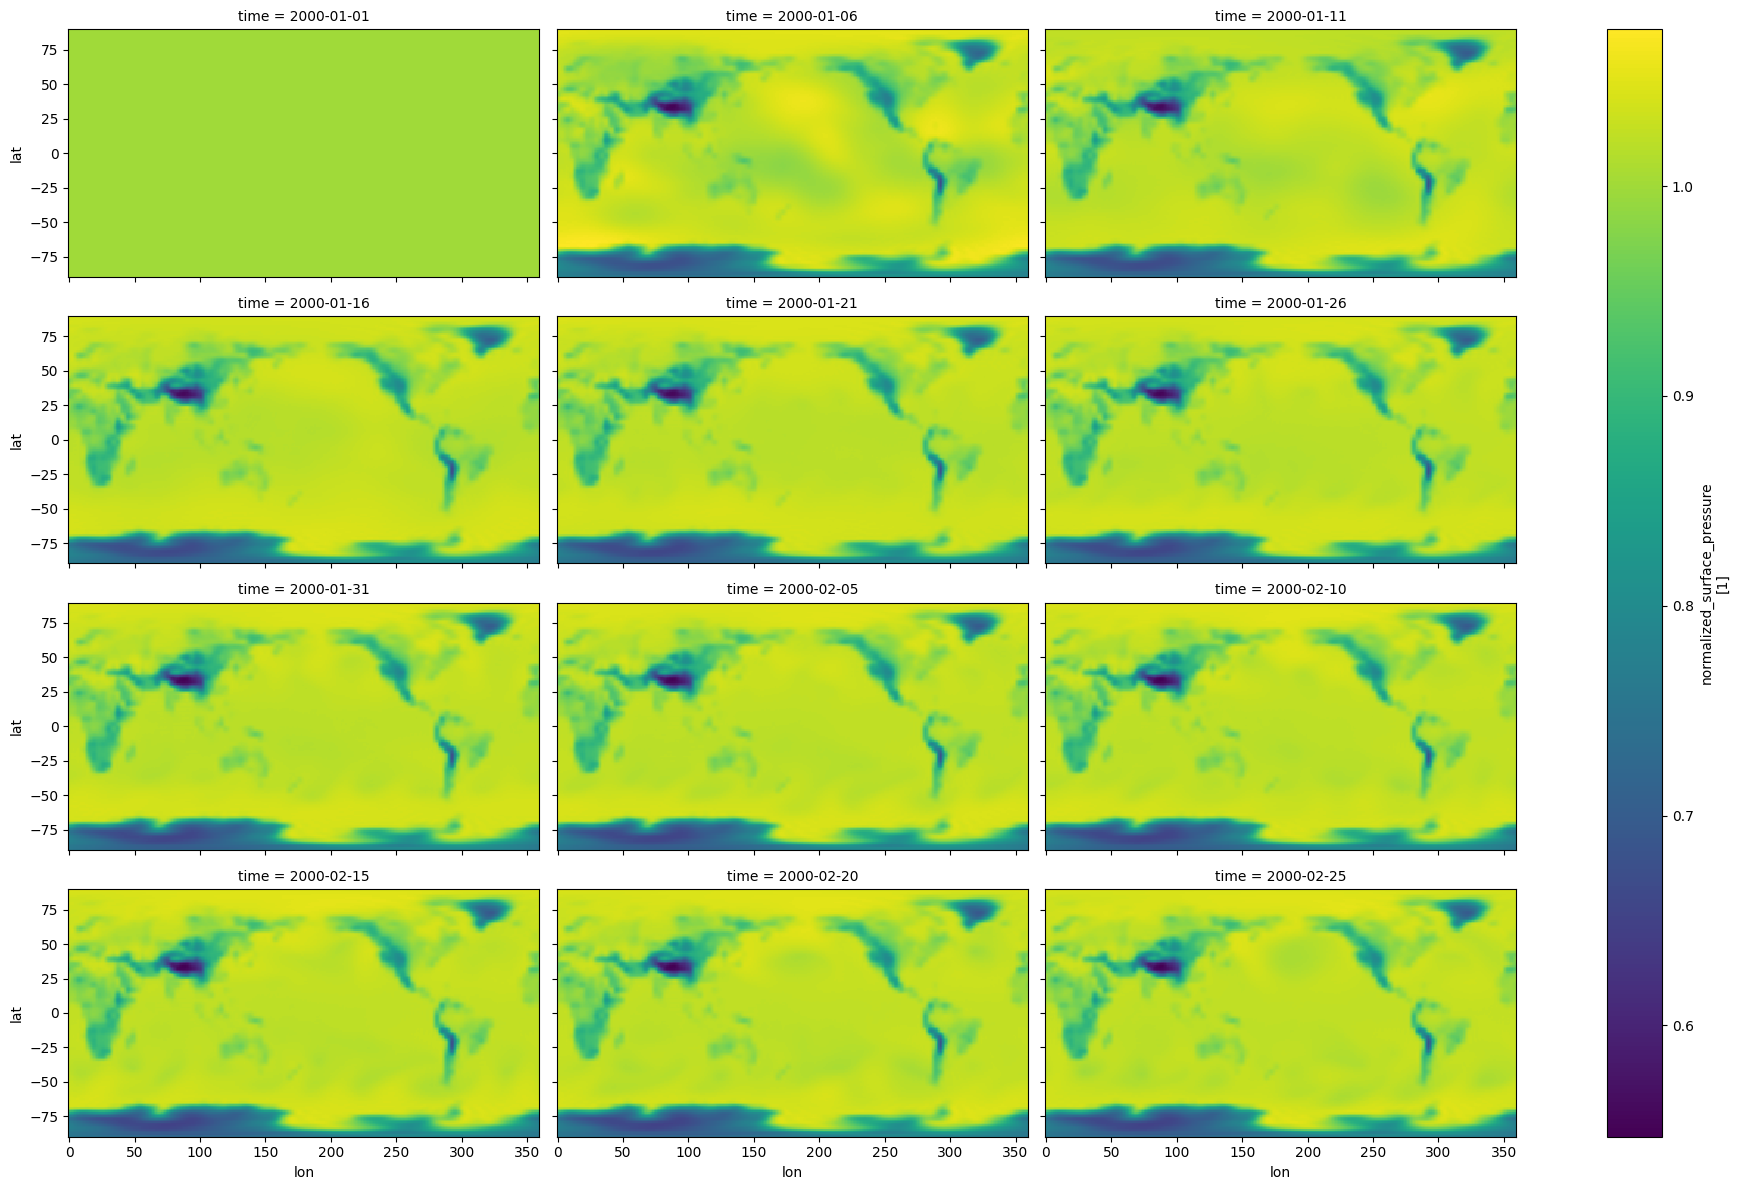

In [8]:
pred_ds['normalized_surface_pressure'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2)

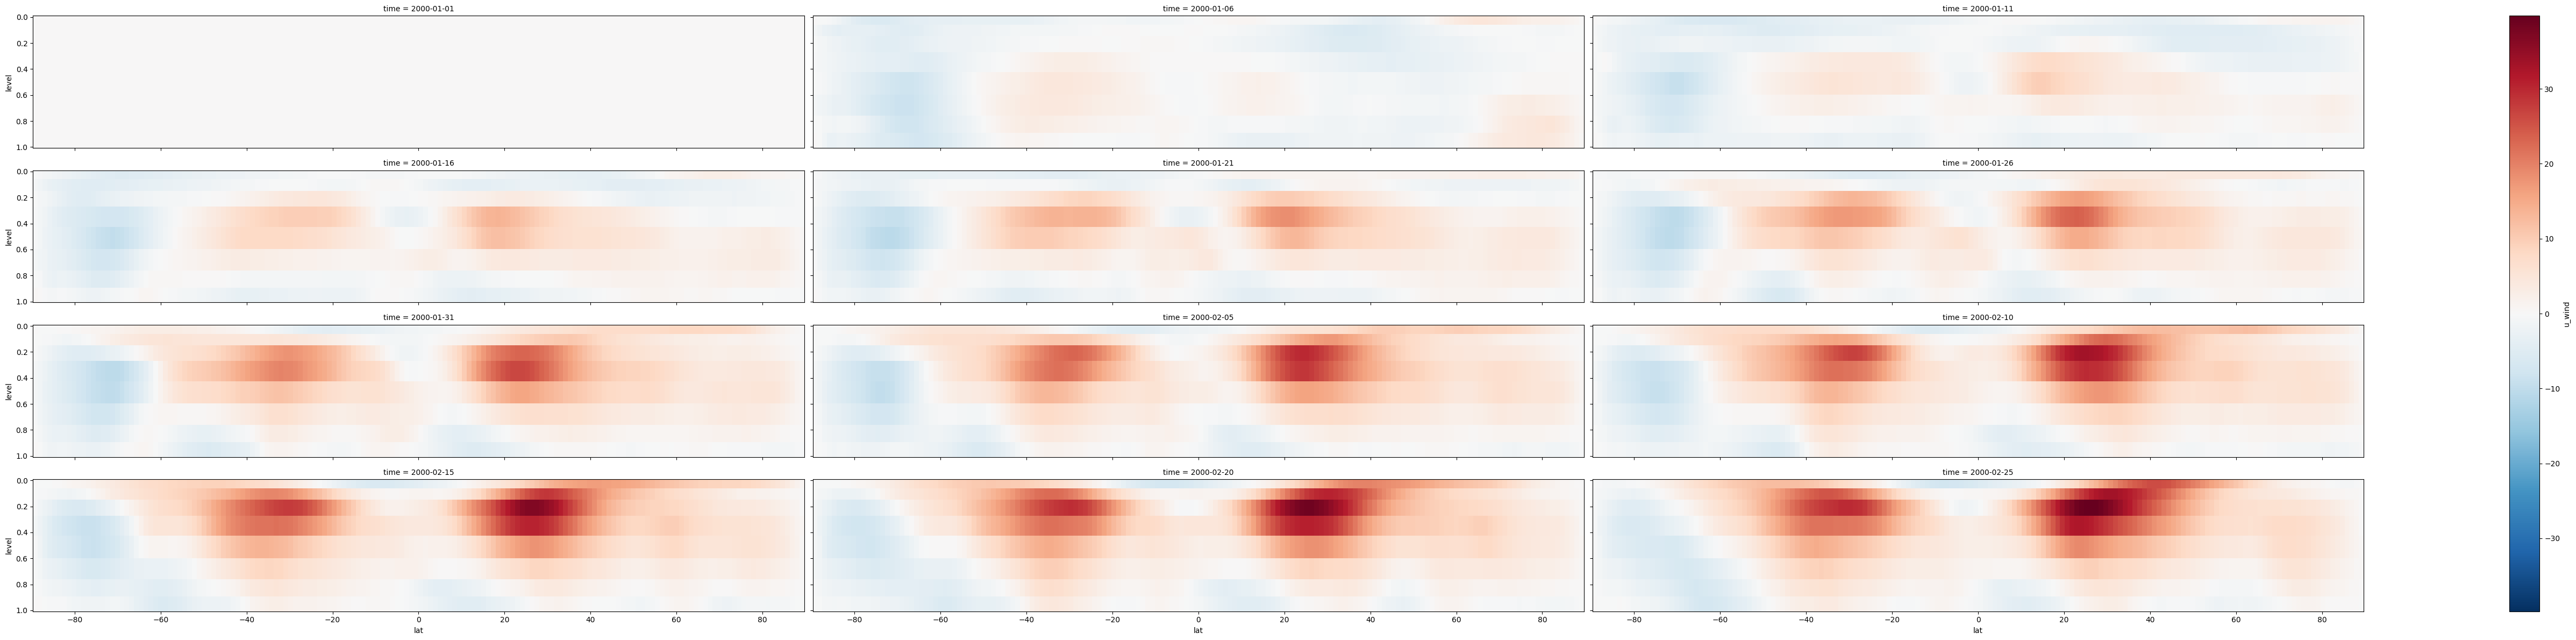

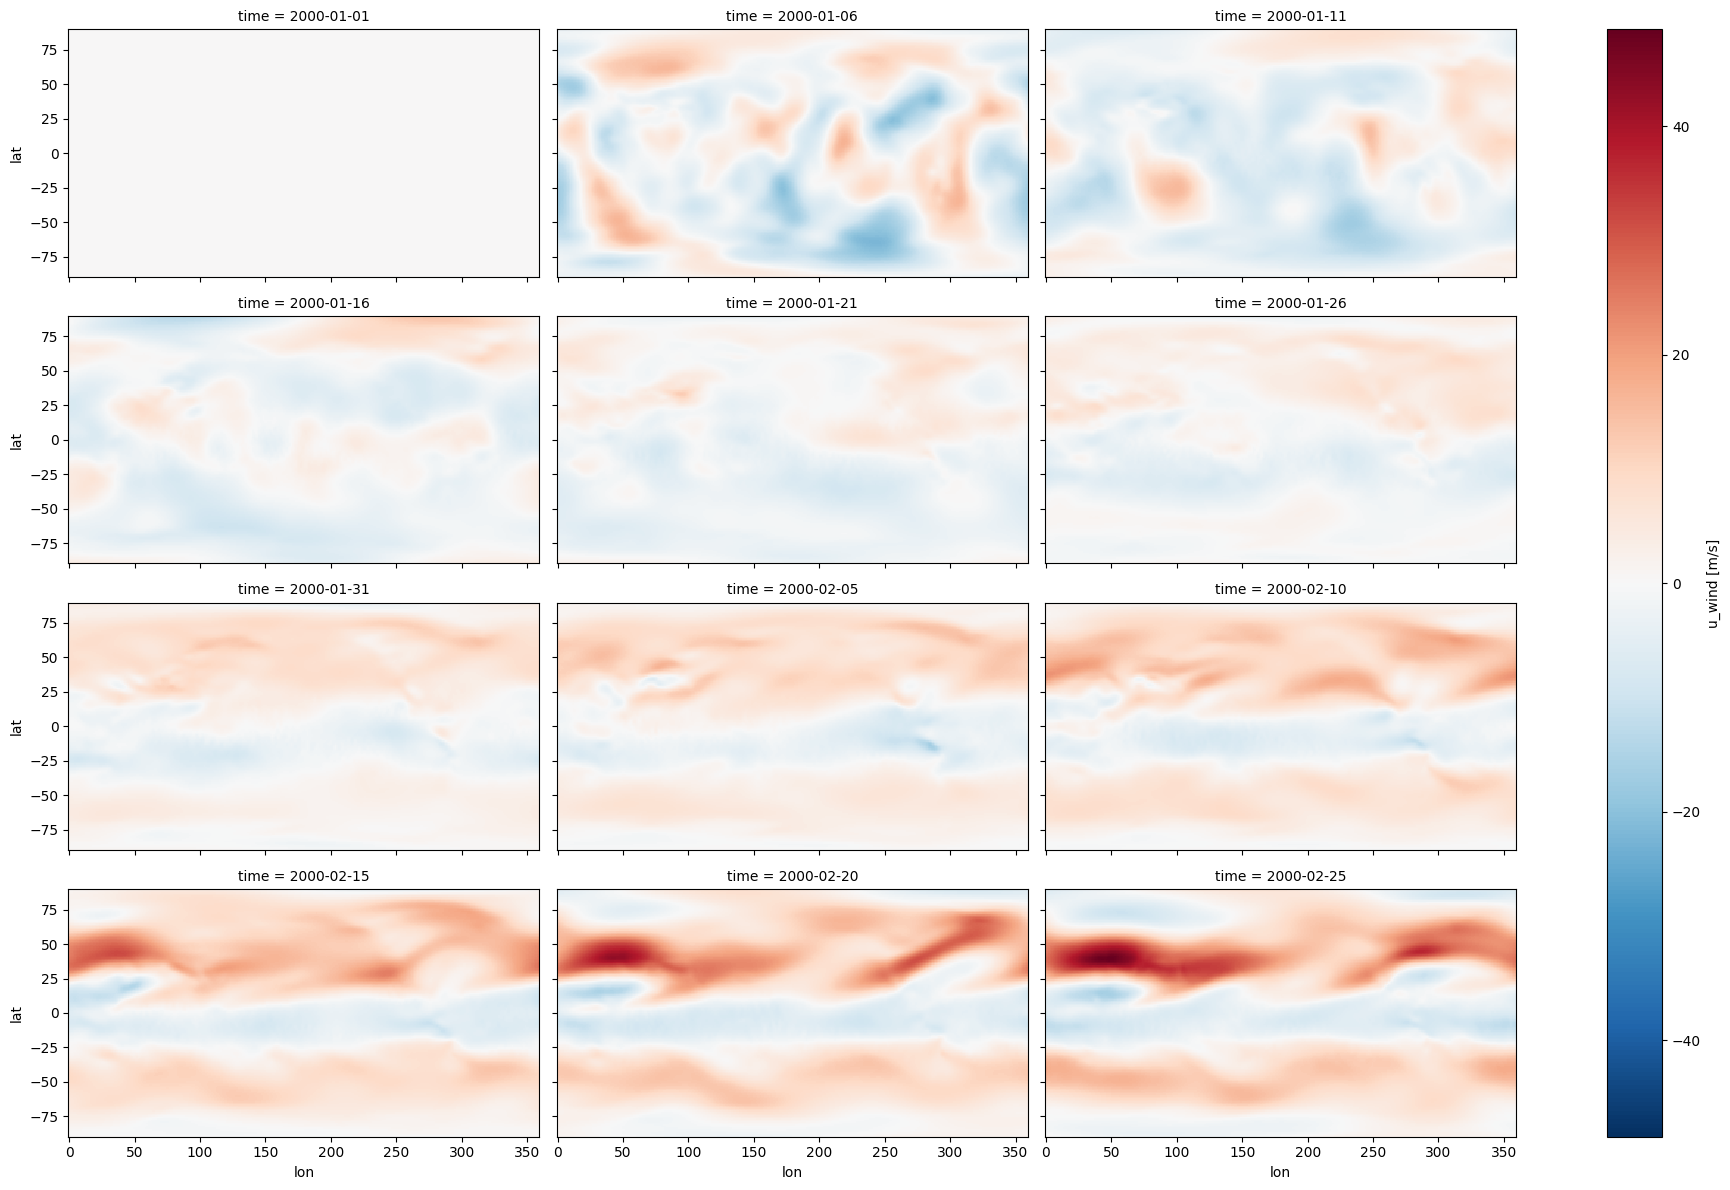

In [9]:
pred_ds['u_wind'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=3, aspect=6, yincrease=False)
pred_ds['u_wind'].isel(level=-1).plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2)

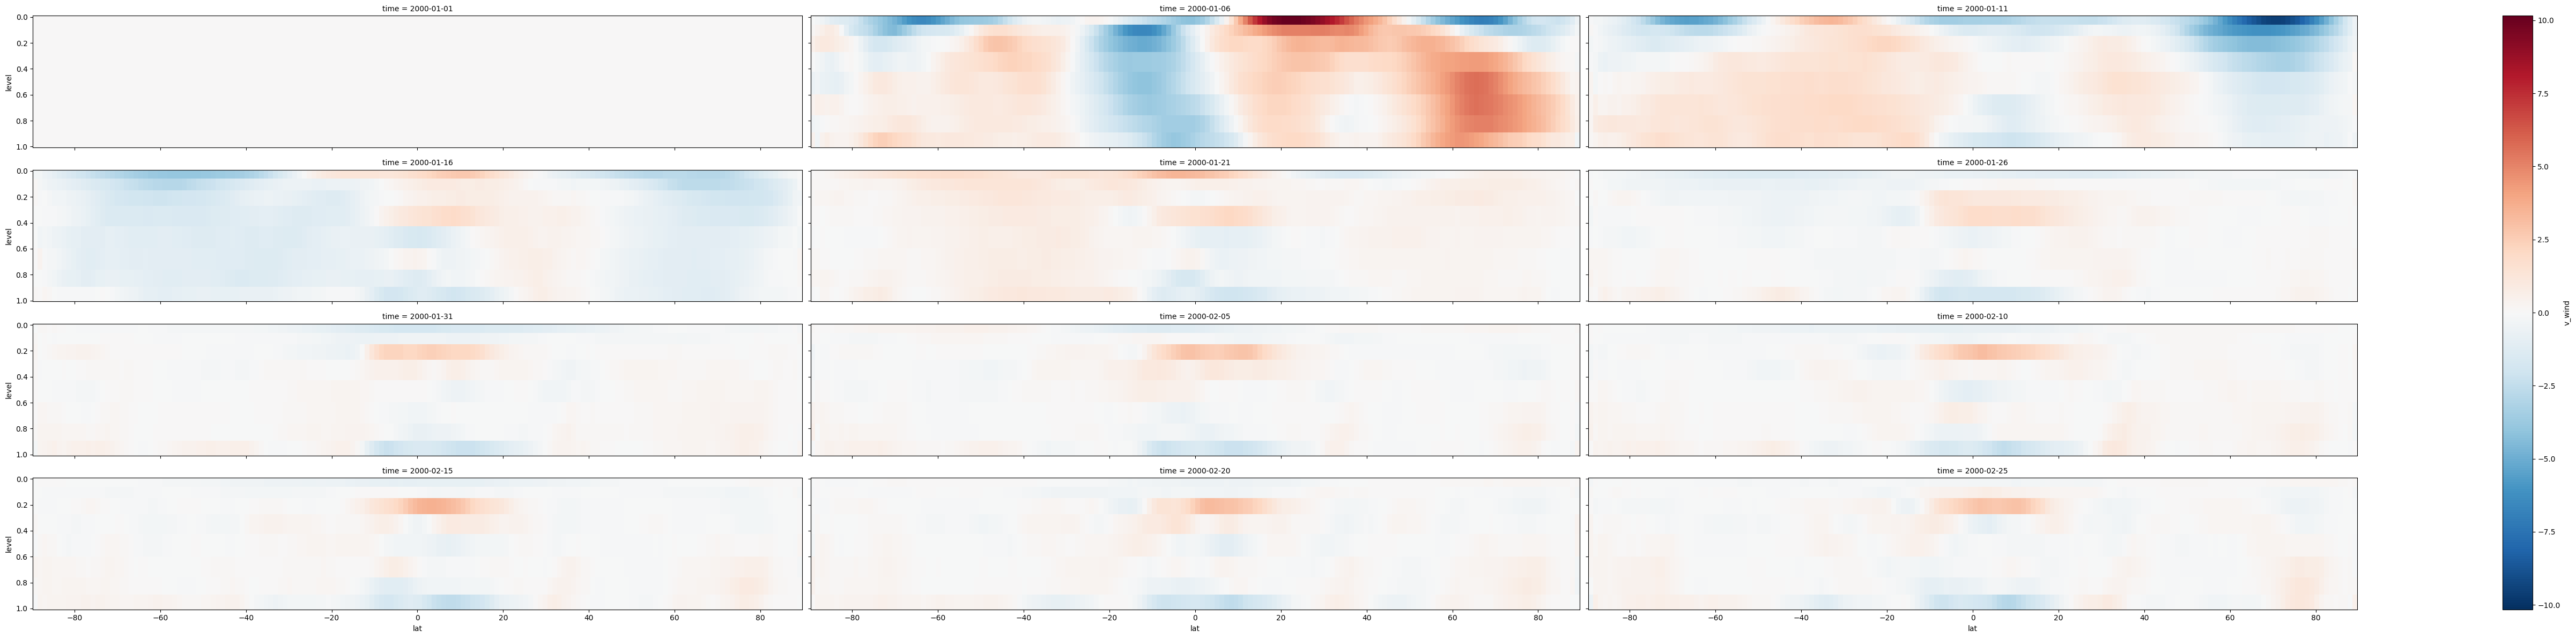

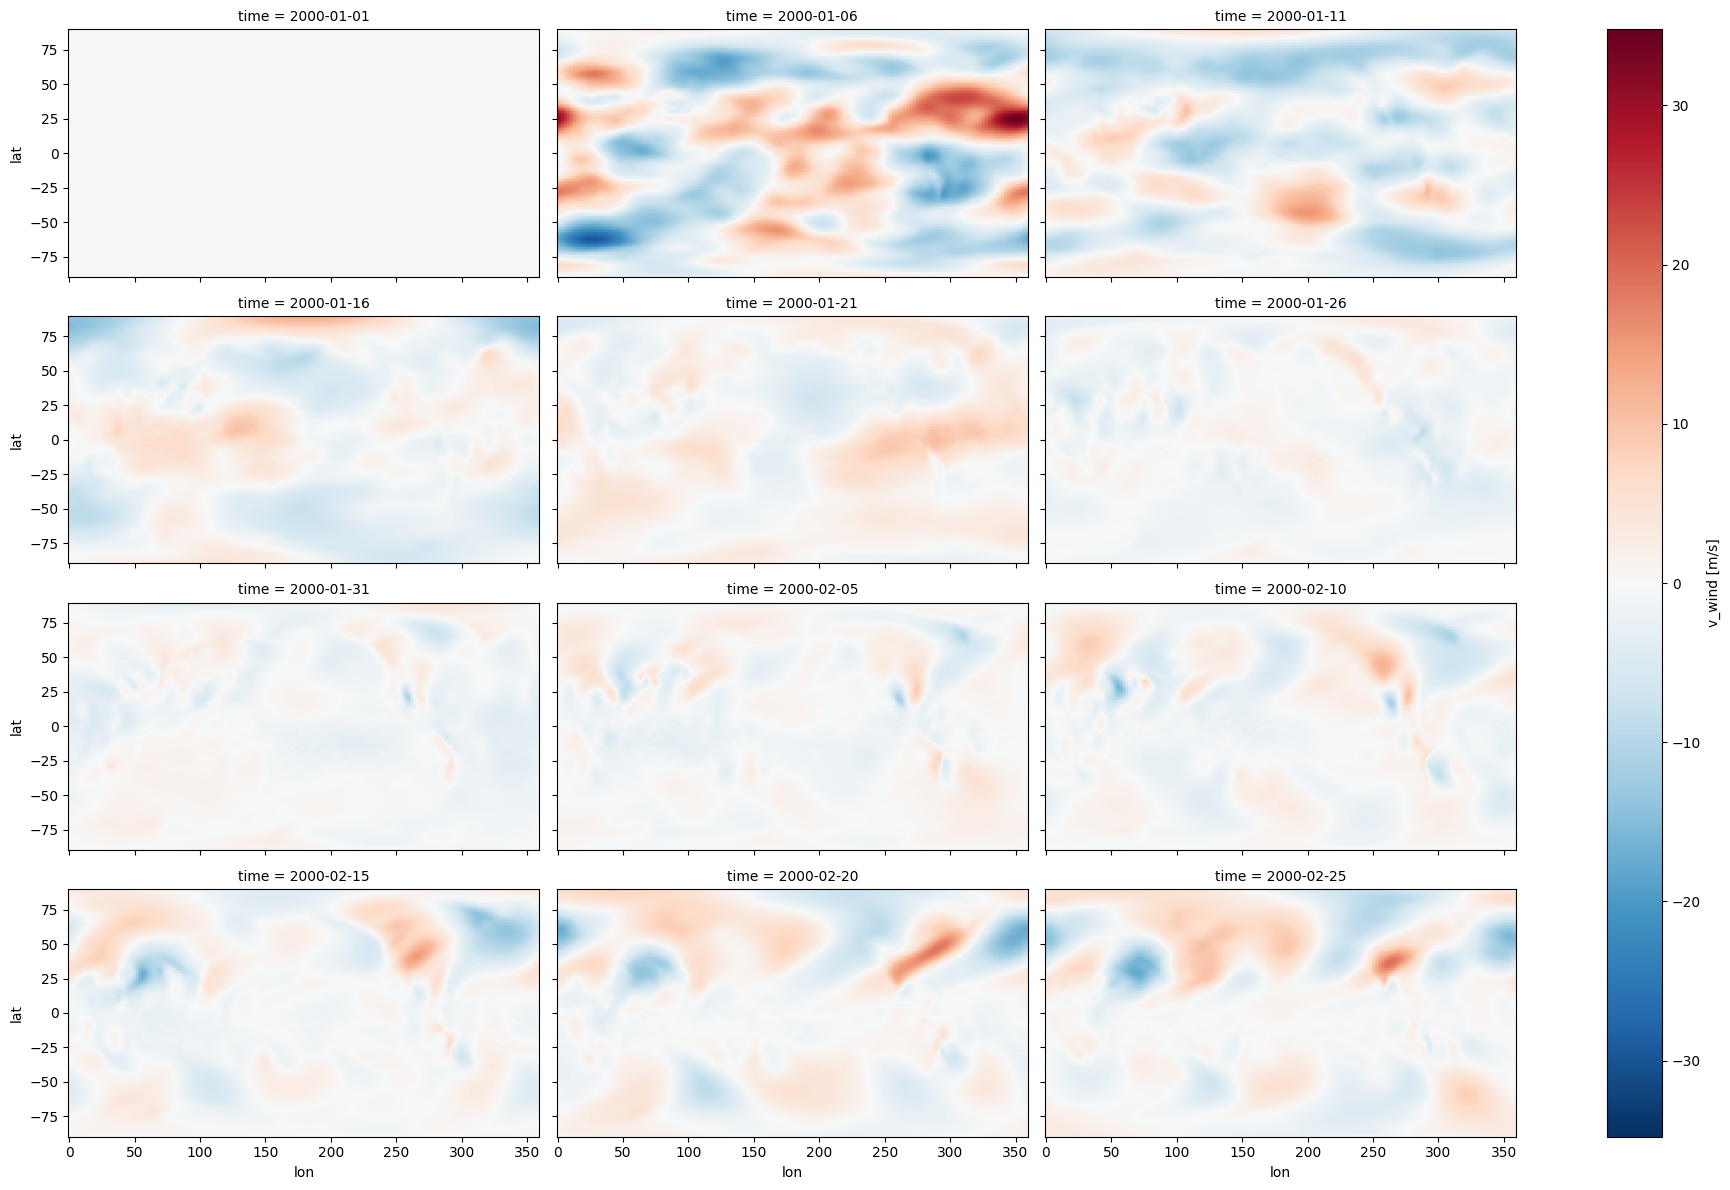

In [10]:
pred_ds['v_wind'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=3, aspect=6, yincrease=False)
pred_ds['v_wind'].isel(level=-1).plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2)

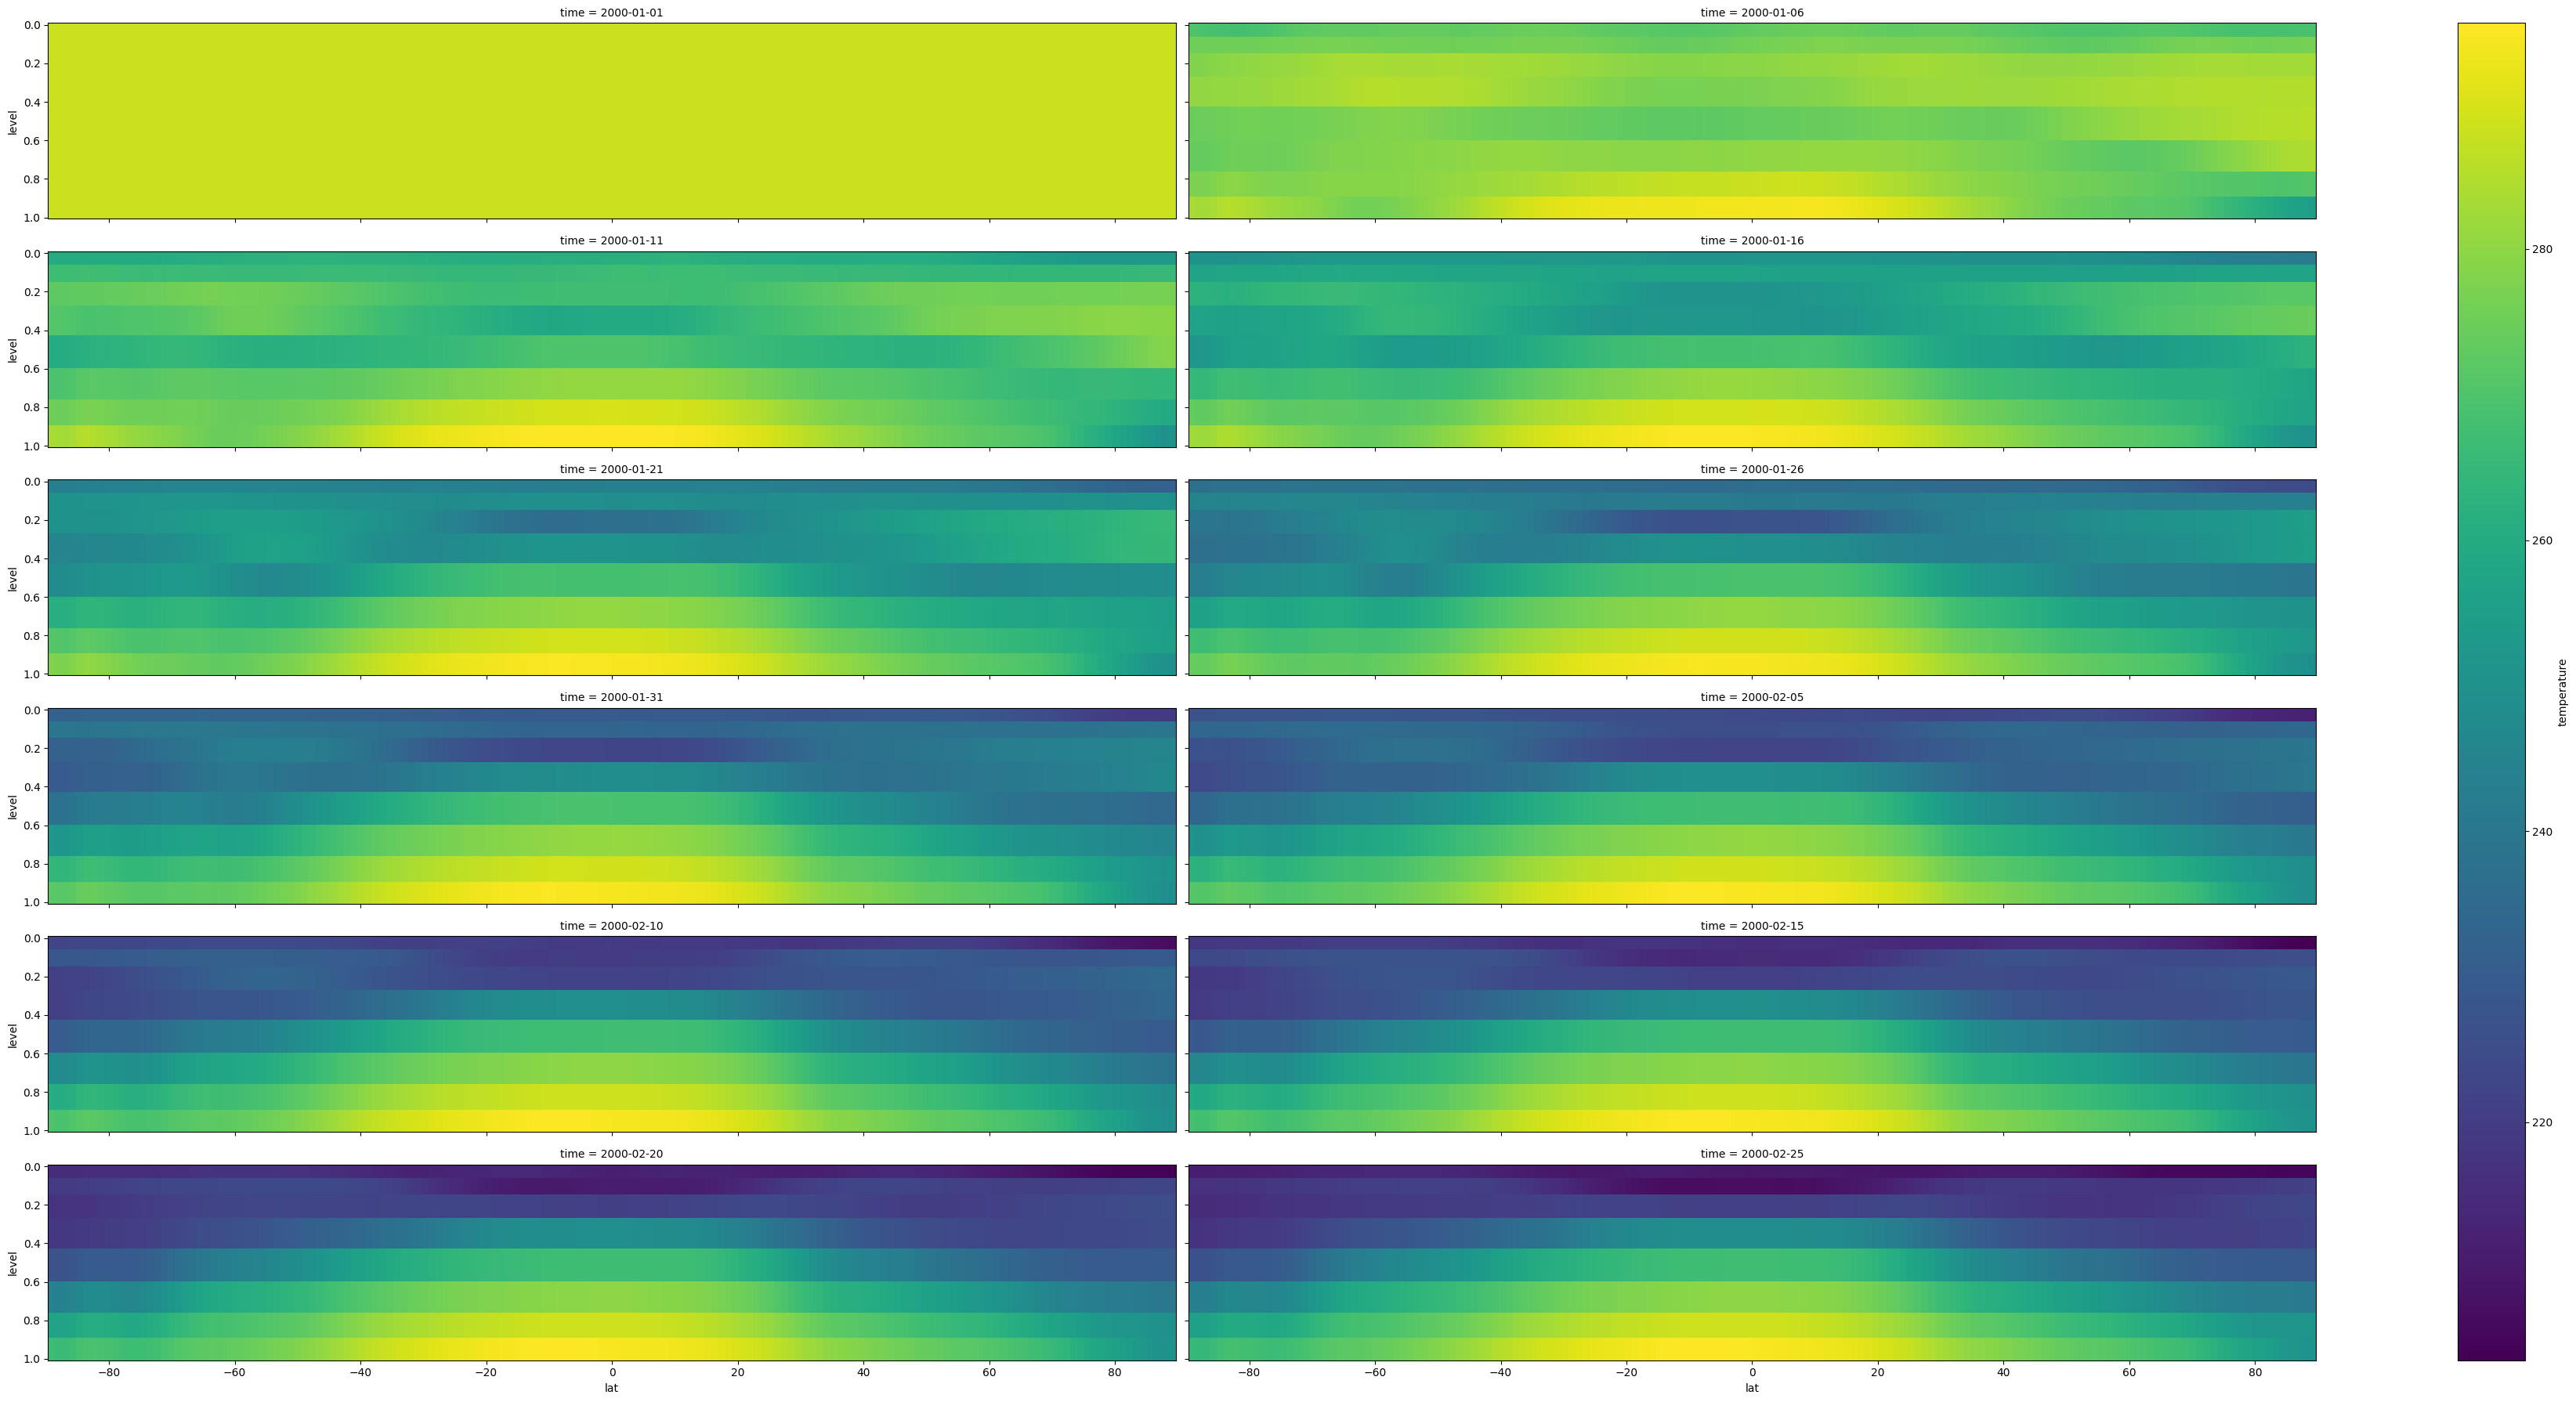

In [11]:
pred_ds['temperature'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=2, aspect=6, yincrease=False)

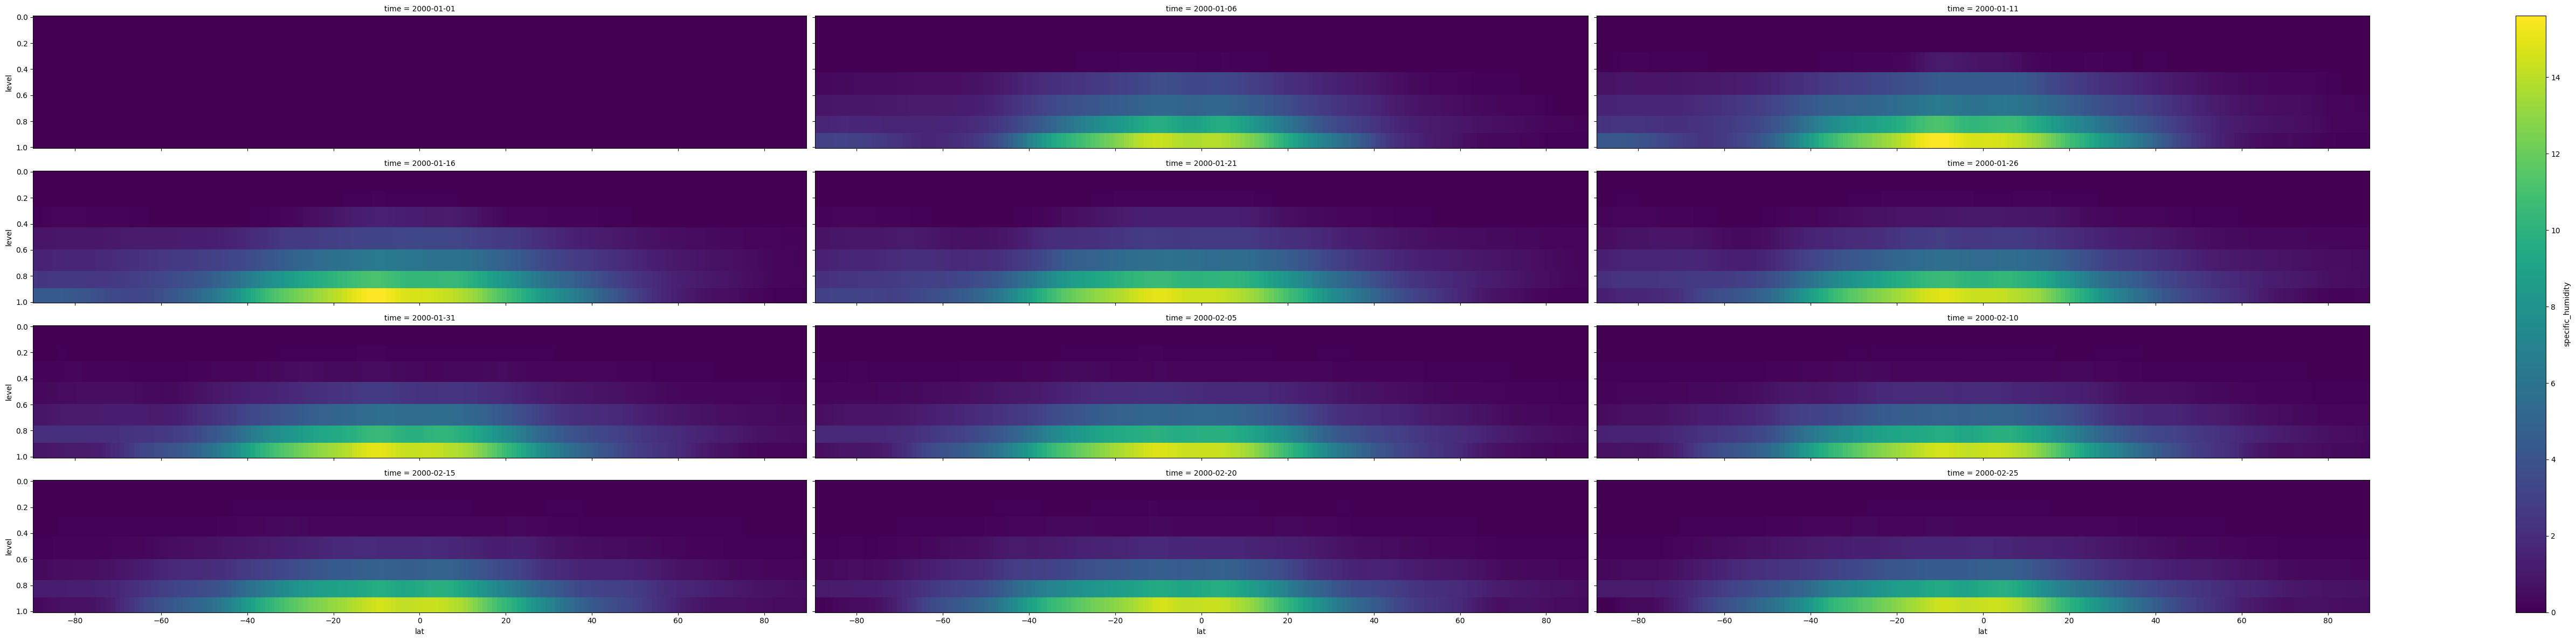

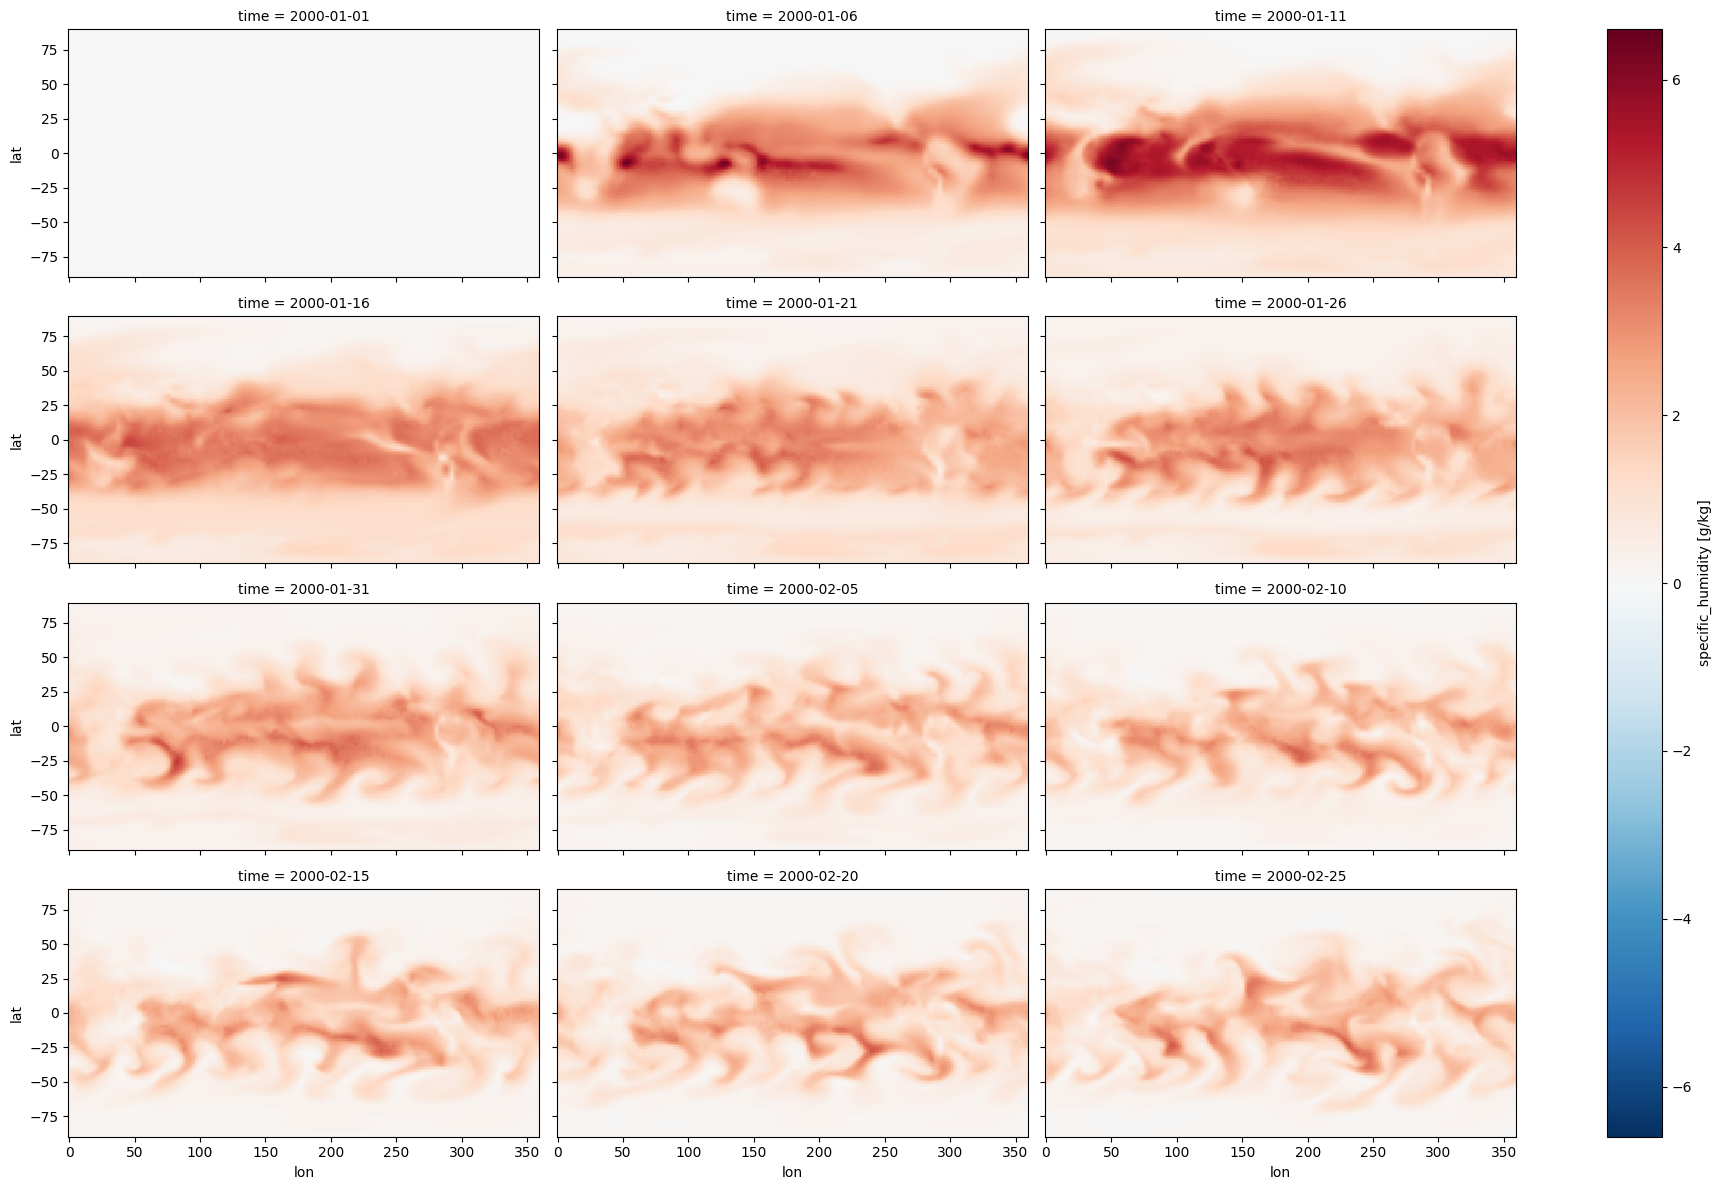

In [12]:
pred_ds['specific_humidity'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=3, aspect=6, yincrease=False)
pred_ds['specific_humidity'].isel(level=3).plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2)

### clouds!

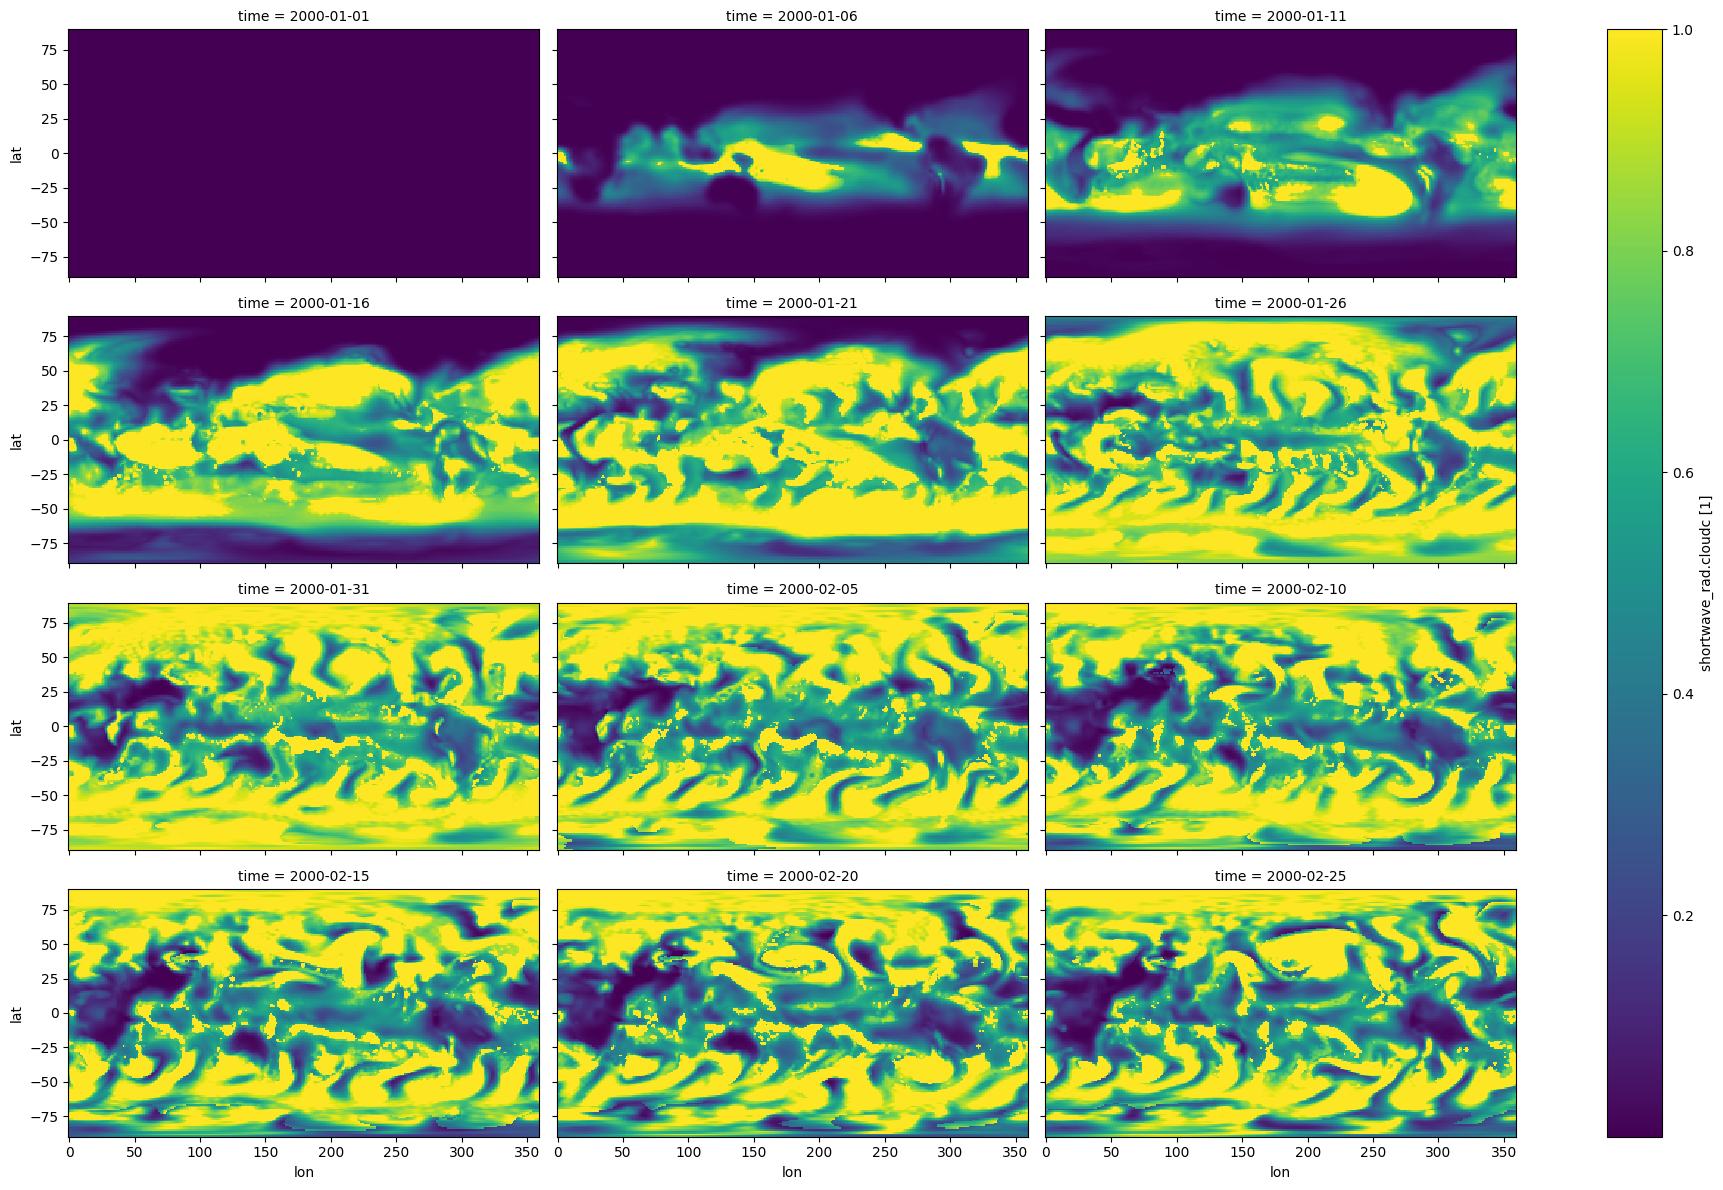

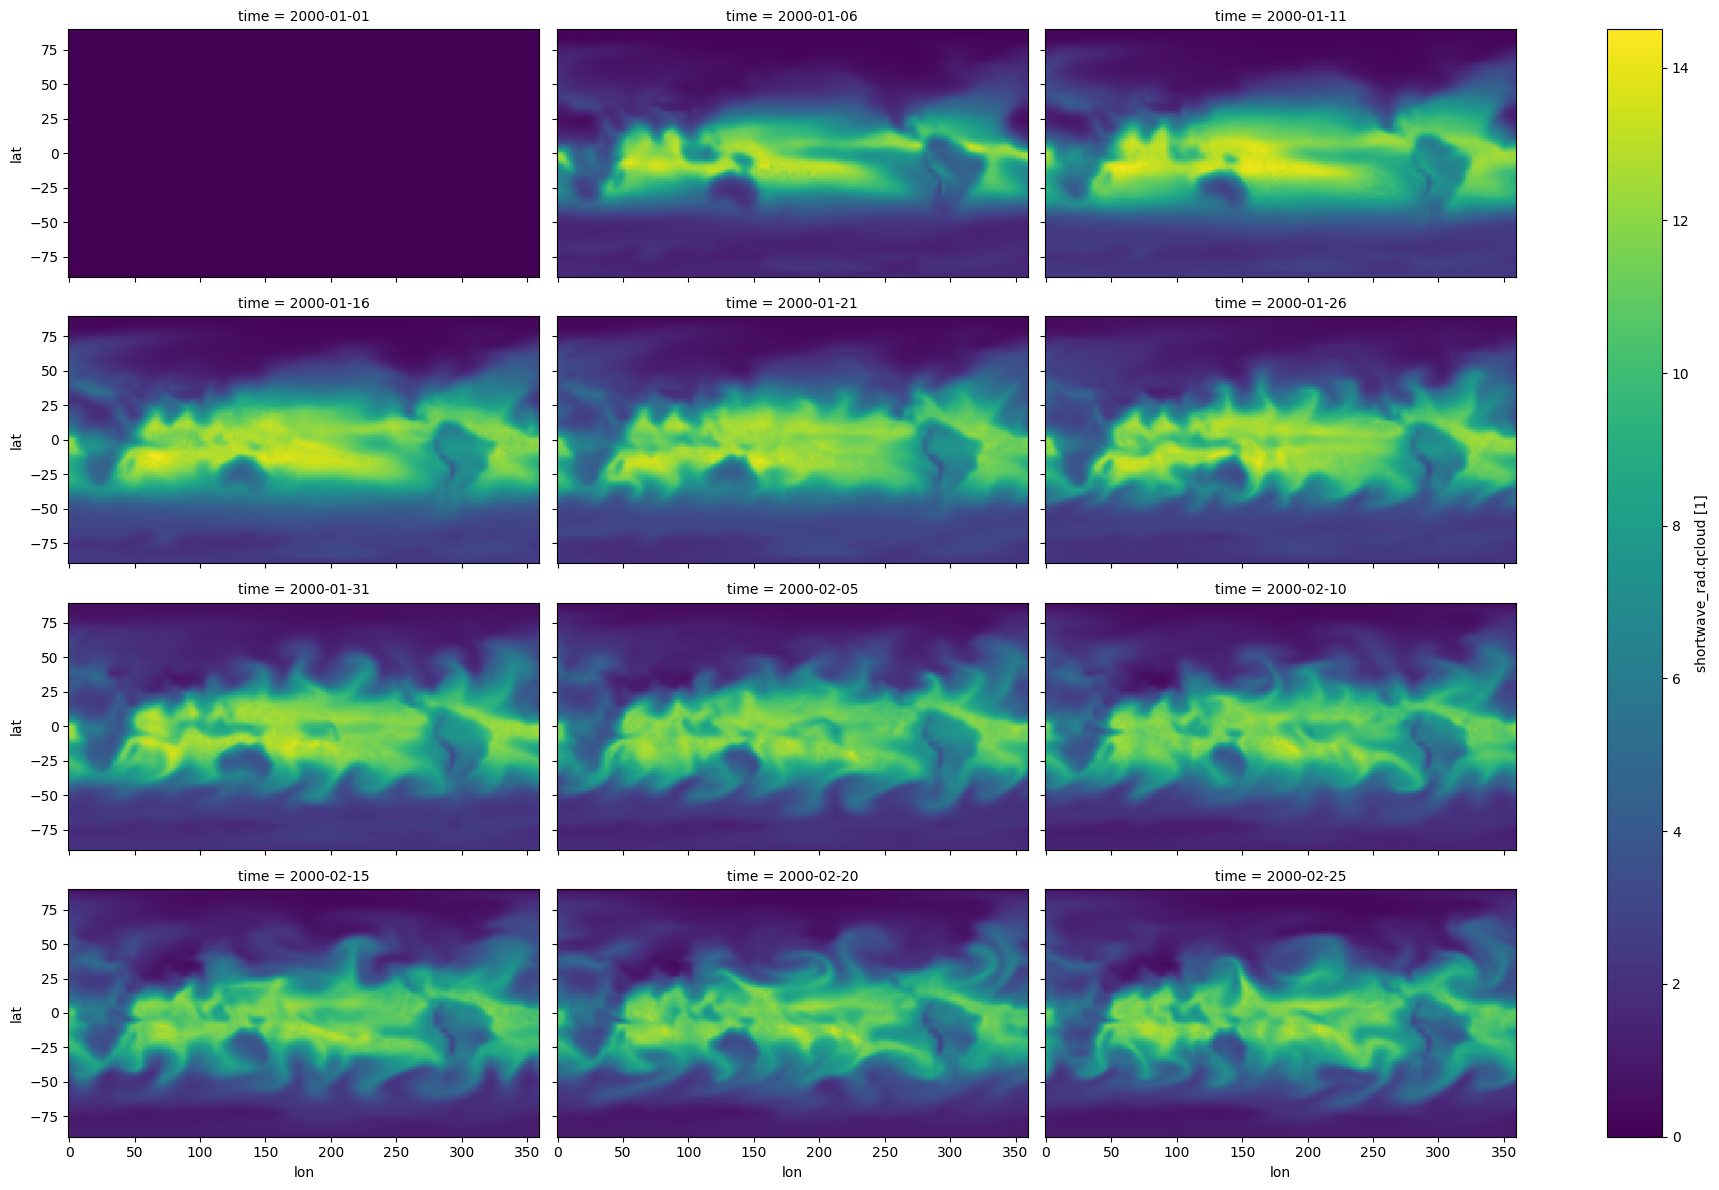

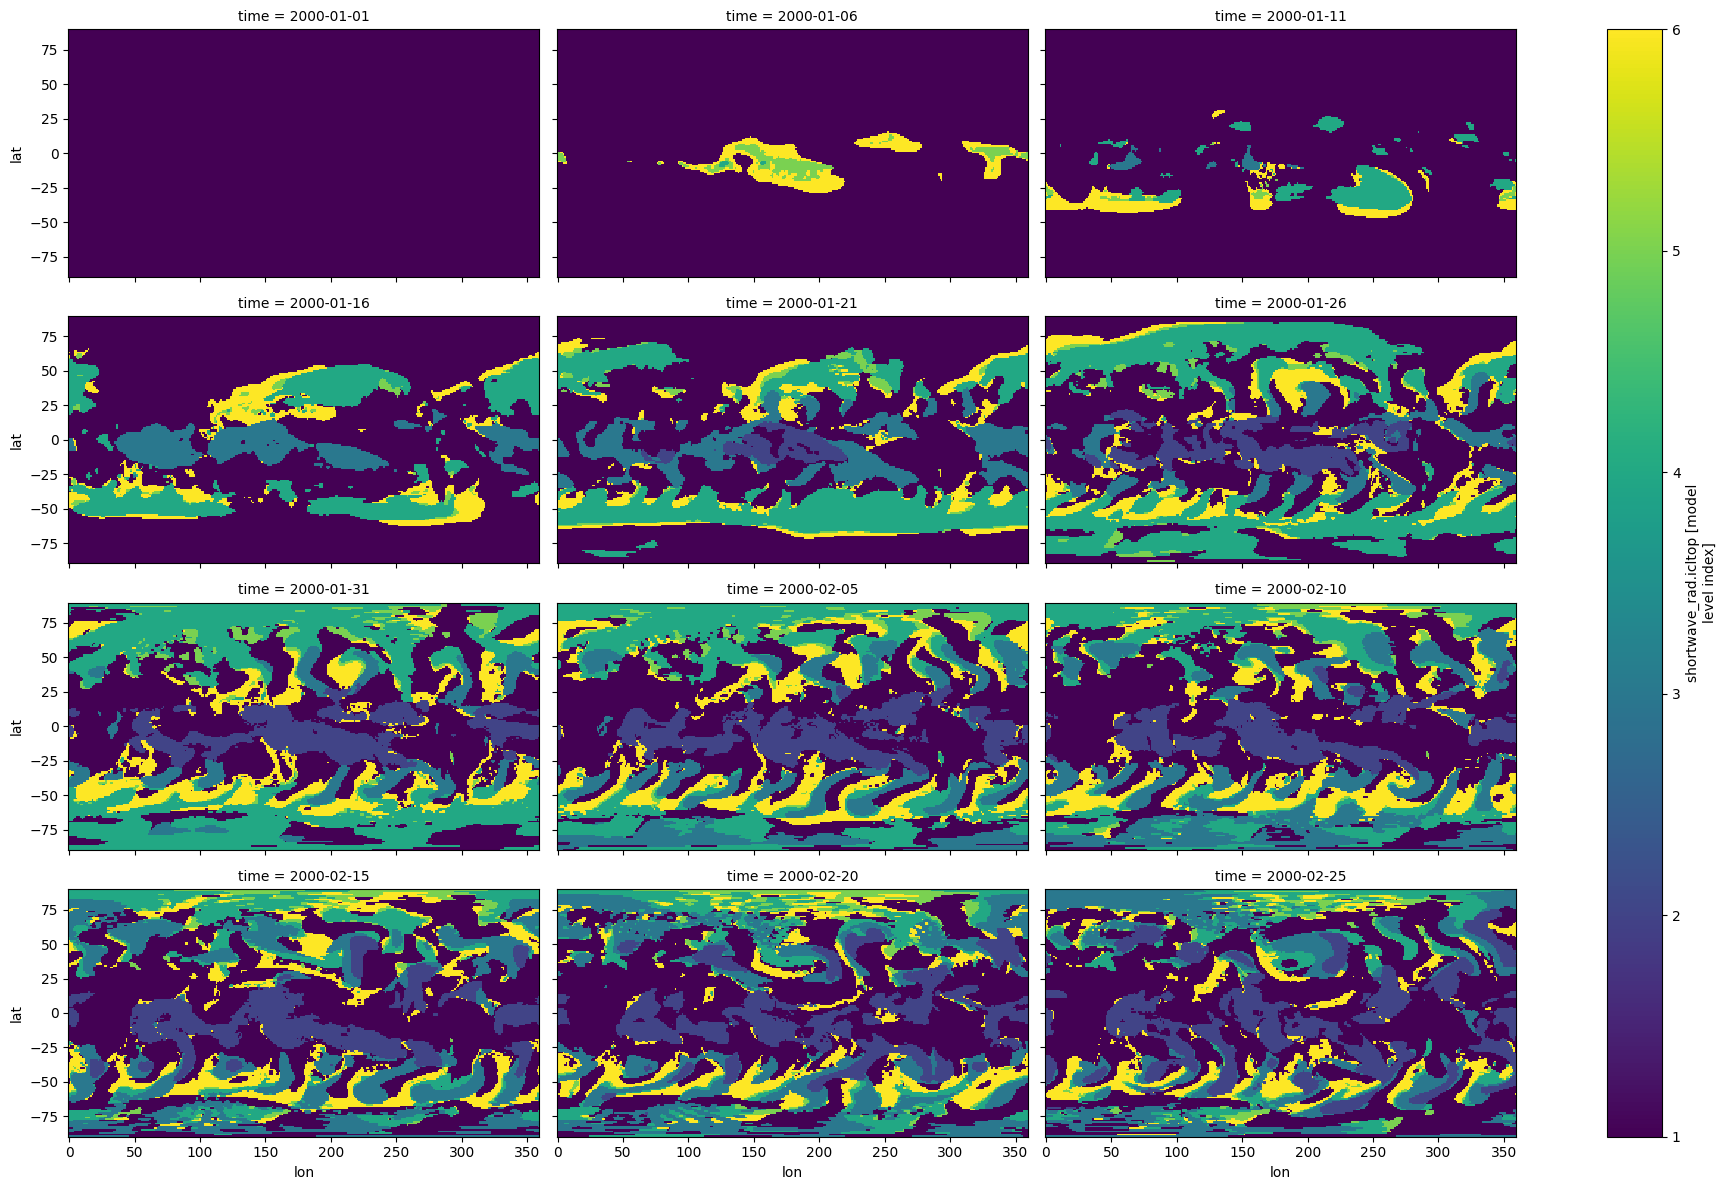

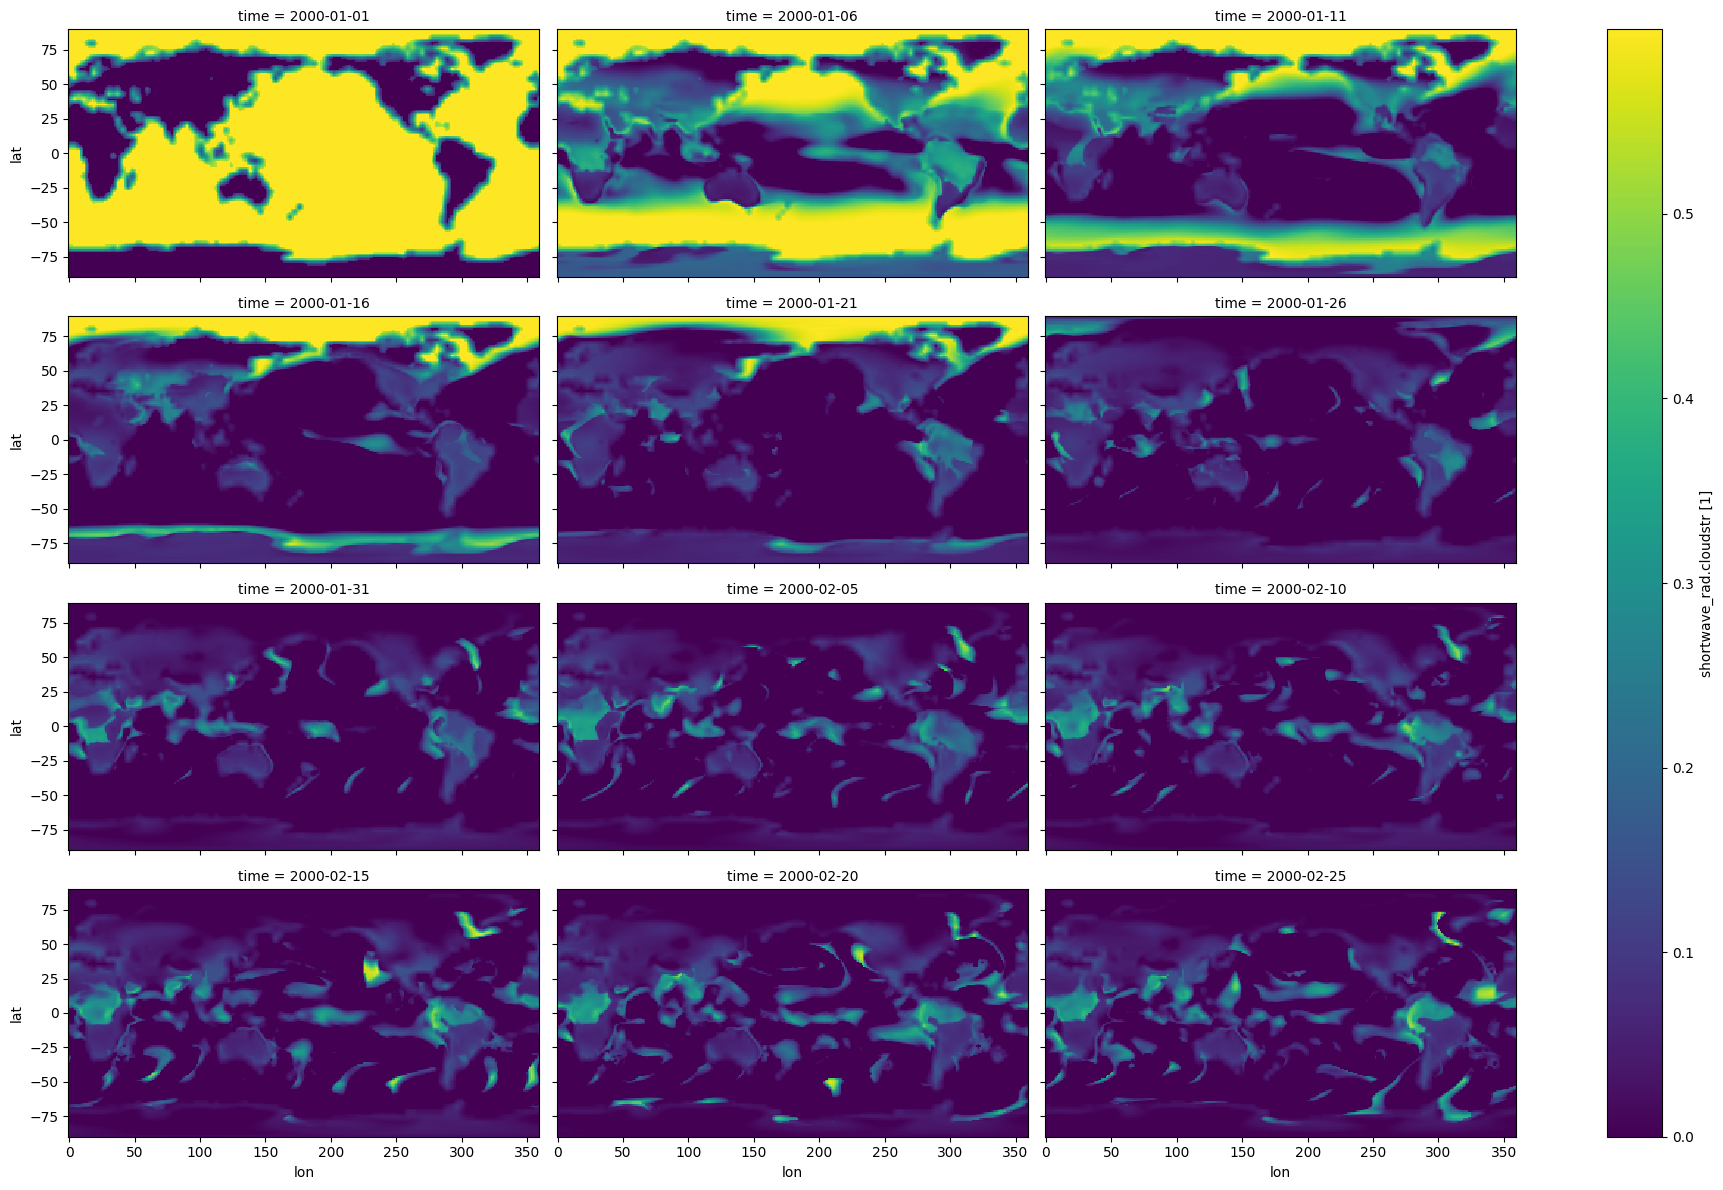

In [13]:
pred_ds['shortwave_rad.cloudc'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2)
pred_ds['shortwave_rad.qcloud'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2)
pred_ds['shortwave_rad.icltop'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2)
pred_ds['shortwave_rad.cloudstr'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2)